(dwave)=

# D-Wave: квантовый отжиг, оптимизация и семплинг

## Описание лекции

В этой лекции мы рассмотрим квантовый отжигатель компании `D-Wave` и задачи, которые можно решать с его помощью. Мы заострим основное внимание на физике и алгоритмах, нежели на hardware-реализации этого устройства. Эта лекция основана на [официальной документации `D-Wave`](https://docs.dwavesys.com/).

## Введение в квантовый отжиг

На сегодняшний день, квантовый отжиг представляет собой отдельную модель квантовых вычислений, не связанную с так называемыми `Gate-Model` квантовыми вычислениями. Эта парадигма позволяет эффективно решать задачи комбинаторной оптимизации больших масштабов, представляющие большой интерес для многих областей науки и индустрии. Вкратце, в модели квантового отжига на физическую модель (коей является массив кубитов) отображаются параметры решаемой задачи, после чего кубиты адиабатически (достаточно медленно) переводятся в основное состояние, которое и кодирует в себе искомое решение. Давайте теперь разберем подробнее данный подход.

## Задачи оптимизации и семплирования

Квантовый отжигатель (`Quantum Annealing Processor`) в силу своей физической реализации приводит к решениям, соответствующим низкоэнергетическим состояниям физической системы. В то время как задачи оптимизации (`Optimization Problems`) требуют глобального минимума энергии, иногда хватает и семплов из состояний, близких к основным. Такие задачи называются задачами семплирования (`Probabilistic Sampling Problems`).

Классическим примером задачи оптимизации в контексте квантового отжига является, например, [задача коммивояжера](https://ru.wikipedia.org/wiki/Задача_коммивояжёра). Квантовая физика, в силу своей природы, может помогать решать такого рода задачи, так как они могут быть переформулированы в задачи дискретной минимизации энергии. Одно из основных правил физики состоит в том, что все физические системы стремятся к состояниям с минимальной энергией. Например, объекты скользят с холмов, горячие вещи со временем остывают и так далее. Этот принцип соблюдается и в мире квантовой физики. Квантовый отжиг просто использует квантовую физику для поиска низкоэнергетических состояний системы и, как следствие, оптимального или почти оптимального решения.

В свою очередь, задачи семплирования, часто являющиеся вычислительно сложными (например, задача семплирования из ограниченной машины Больцмана), идеально подходят к квантовым отжигателям в случае когда необходимо построить вероятностную модель, а доступ к полному вероятностному распределению состояний не представляется возможным. Такая постановка задачи подходит например, чтобы обучить модель генерировать изображения рукописных цифр из знаменитого датасета `MNIST`. По этой теме можно послушать [доклад](https://ods.ai/tracks/quantum-computing-df2021/blocks/67a583ab-0dc6-4b4f-93c8-209aa1d352e1) Никиты Щуцкого "Quantum-Classical Neural Networks in Computational Drug Design", сделанный в рамках трека ODS по квантовым вычислениям.

## Квантовая физика под капотом

Как мы уже знаем, квантовый гамильтониан является оператором, ставящим в соответствие собственным состояниям системы ее энергии. Множество собственных чисел гамильтониана называется его спектром. В квантовом отжигателе `D-Wave` гамильтониан имеет следующую форму:

$$\mathcal{H}_{Ising}=\underbrace{{-A(t)}\left(\sum_{i} \hat{\sigma}_{x}^{(i)}\right)}_{\text {Initial Hamiltonian }}+\underbrace{{B(t)}\left(\sum_{i} h_{i} \hat{\sigma}_{z}^{(i)}+\sum_{i,j} J_{i, j} \hat{\sigma}_{z}^{(i)} \hat{\sigma}_{z}^{(j)}\right)}_{\text {Final Hamiltonian }}$$

, где $A(t)$, $B(t)$ являются функциями от времени $t \in [0, T]$, $\hat{\sigma}_{x, z}^{(i)}$ -- операторами Паули, действующими на кубиты, а $h_i$ и $J_{i,j}$ -- локальными полями и взаимодействиями кубитов соответственно. Физически, вектор $h$ соответствует внешнему магнитному полю, применимому к каждому кубиту. В свою очередь, матрица $J$ отвечает за попарные $ZZ$ взаимодействия кубитов. Функции $A(t)$, $B(t)$ должны быть такими, что $A(0)=B(T)=1$, $A(T)=B(0)=0$, то есть гамильтониан со временем полностью переходит из $\mathcal{H}_{Initial}$ в $\mathcal{H}_{Final}$. Вид этих функций называется расписанием отжига или `annealing schedule`.

```{figure} /_static/dwaveblock/dwave/fig_3.png
:name: fig_1
:width: 500px

Пример расписания отжига: функций $A(t)$, $B(t)$.
```

Отметим также, что матрица взаимодействий кубитов $J_{i,j}$ ограничена графом взаимодействий кубитов, который обычно фиксирован. Для практического применения в коде детальное представление этого графа знать не нужно, но ознакомиться с ним можно на специально посвященной этому [странице документации `D-Wave`](https://docs.dwavesys.com/docs/latest/c_gs_4.html#getting-started-topologies).

Разберем подробно, что же представляет собой данный гамильтониан. Начальный гамильтониан $\mathcal{H}_{Initial}$ представляет собой гамильтониан с основным состоянием состоящим из суперпозиции $0$ и $1$. Этот гамильтониан в литературе также называется `tunneling Hamiltonian`. Финальный гамильтониан $\mathcal{H}_{Final}$, в свою очередь, является гамильтонианом задачи (его называют также `Problem Hamiltonian`), чье основное состояние и представляет собой решение, параметры которого находятся в матрице взаимодействий кубитов $J_{i,j}$ и векторе локальных полей $h_i$. Обратим наше внимание на тот факт, что $\mathcal{H}_{Final}$ -- полностью классический гамильтониан, он диагонален в вычислительном базисе (базисе $\sigma_z$). Каждое собственное (классическое) состояние этого гамильтониана соответствует классической функции потерь для решаемой задачи.

Таким образом, в квантовом отжиге система инициализируется в основном состоянии начального гамильтониана -- такое состояние легко приготовить экспериментально, то есть система легко переходит в основное состояние начального гамильтониана в силу его простоты. По мере самого отжига, в силу [адиабатической теоремы](https://ru.wikipedia.org/wiki/Адиабатическая_теорема), основное состояние начального гамильтониана переходит в основное состояние финального гамильтониана. Для наглядности, на графике ниже (взят из [этой](https://arxiv.org/pdf/1903.06559.pdf) статьи) показано типичное поведение первых энергетических уровней гамильтониана. Основному состоянию соответствует кривая с наименьшей энергией.

```{figure} /_static/dwaveblock/dwave/fig_1.png
:name: fig_2
:width: 500px

Типичная зависимость от времени энергетических уровней гамильтонианов, используемых в квантовом отжиге
```

Очень важно отметить, что для успеха данного алгоритма необходимо выполнение условий адиабатической теоремы:

1. во-первых, минимальная энергетическая щель $\Delta_{\text{min}}$ (разница энергий основного и первого возбужденного состояний) не должна обращаться в $0$ в любой момент времени,

2. а во-вторых, функции $A(t)$ и $B(t)$ должны меняться достаточно медленно.

Можно показать, что второе условие может быть переформулировано в виде $T \gg \frac{1}{\Delta^2_{\text{min}}}$. Именно это неравенство ответственно за наибольшую проблему, с которой можно столкнуться при практической реализации данного алгоритма. В частности, из него видно, что время алгоритма зависит от минимальной (за все время алгоритма) энергетической щели, которая не должна быть слишком маленькой, иначе время алгоритма станет слишком большим. Если же щель будет слишком большой (что соответствует быстрому отжигу), то система может перейти в возбужденное состояние. Однако, основные состояний начального и финального гамильтонианов являются, качественно, сильно разными. Основное состояние начального гамильтониана является тривиальным, в то время как основное состояние финального гамильтониана кодирует в себе решение сложной задачи оптимизации. Это наталкивает нас на мысль, что в течение процесса квантового отжига наша система может пережить квантовый фазовый переход.

Для квантовых фазовых переходов первого рода известно, что $\Delta_{\text{min}} \propto e^{-N}$, где $N$ -- количество кубитов, что приводит к $T \propto e^{2N}$, то есть экспоненциально большому времени алгоритма. В этом случае задача считается "сложной", так как алгоритм не масштабируется.

В свою очередь, для квантовых фазовых переходов второго рода верно, что $\Delta_{\text{min}} \propto N^{-l}$ ($l>0$), что приводит к $T \propto N^{2l}$, то есть полиномиальному времени алгоритма и задача считается "простой".

## Пример: задача раскраски графа

Давайте теперь попробуем решить с помощью квантового отжига следующую задачу комбинаторной оптимизации -- [задачу раскраски графа](https://ru.wikipedia.org/wiki/Раскраска_графов), или, как она называется в англоязычной литературе -- `graph coloring problem`. В этой задаче нам необходимо с помощью заданного числа цветов присвоить цвет каждой вершине графа так, чтобы любые две вершины, имеющие общее ребро, имели разные цвета. Назовем наш граф $G=(E,V)$, где $E$ -- множество ребер, а $V$ -- множество вершин. Для наглядности, мы рассмотрим эту задачу в виде раскраски карты Канады четырьмя цветами -- нам необходимо каждой канадской провинции (аналогу штата в США) присвоить цвет так, чтобы все граничащие провинции имели разные цвета. Этот пример находится также в [документации](https://docs.ocean.dwavesys.com/en/latest/examples/map_coloring.html#map-coloring) `D-Wave`. Визуально, решение этой задачи будет выглядеть как на следующем графике.

```{figure} /_static/dwaveblock/dwave/fig_2.png
:name: fig_3
:width: 500px

Раскрас карты Канады с помощью четырех цветов.
```

`D-Wave` предоставляют нам доступ к трем видам бэкендов: квантовому, классическому и гибридному. Так как наш курс посвящен квантовому машинному обучению, мы воспользуемся непосредственно квантовым отжигателем. Для этого нам необходимо получить токен, который генерируется в личном кабинете пользователя при регистрации в [облачном сервисе D-Wave](https://cloud.dwavesys.com/leap/).

Импортируем нужные библиотеки.

In [1]:
import dwavebinarycsp
from dwave.system import DWaveSampler, EmbeddingComposite
import networkx as nx
import matplotlib.pyplot as plt

Отобразим нашу задачу на граф, где провинции будут вершинами графа, а границы -- его ребрами. Например `(AB, BC)` -- ребро, соответствующее границе между провинциями Альберта и Британская Колумбия. Обозначения провинций представлены в таблице ниже.

<table class="colwidths-given docutils align-default" id="id3">
<caption><span class="caption-text">Обозначения провинций Канады</span><a class="headerlink" href="#id3" title="Permalink to this table">¶</a></caption>
<colgroup>
<col style="width: 17%" />
<col style="width: 33%" />
<col style="width: 17%" />
<col style="width: 33%" />
</colgroup>
<thead>
<tr class="row-odd"><th class="head"><p>Code</p></th>
<th class="head"><p>Province</p></th>
<th class="head"><p>Code</p></th>
<th class="head"><p>Province</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p>AB</p></td>
<td><p>Alberta</p></td>
<td><p>BC</p></td>
<td><p>British Columbia</p></td>
</tr>
<tr class="row-odd"><td><p>MB</p></td>
<td><p>Manitoba</p></td>
<td><p>NB</p></td>
<td><p>New Brunswick</p></td>
</tr>
<tr class="row-even"><td><p>NL</p></td>
<td><p>Newfoundland and Labrador</p></td>
<td><p>NS</p></td>
<td><p>Nova Scotia</p></td>
</tr>
<tr class="row-odd"><td><p>NT</p></td>
<td><p>Northwest Territories</p></td>
<td><p>NU</p></td>
<td><p>Nunavut</p></td>
</tr>
<tr class="row-even"><td><p>ON</p></td>
<td><p>Ontario</p></td>
<td><p>PE</p></td>
<td><p>Prince Edward Island</p></td>
</tr>
<tr class="row-odd"><td><p>QC</p></td>
<td><p>Quebec</p></td>
<td><p>SK</p></td>
<td><p>Saskatchewan</p></td>
</tr>
<tr class="row-even"><td><p>YT</p></td>
<td><p>Yukon</p></td>
<td></td>
<td></td>
</tr>
</tbody>
</table>

In [2]:
provinces = ['AB', 'BC', 'MB', 'NB', 'NL', 'NS', 'NT', 'NU', 'ON', 'PE', 'QC', 'SK', 'YT']
neighbors = [('AB', 'BC'), ('AB', 'NT'), ('AB', 'SK'), ('BC', 'NT'), ('BC', 'YT'),
             ('MB', 'NU'), ('MB', 'ON'), ('MB', 'SK'), ('NB', 'NS'), ('NB', 'QC'),
             ('NL', 'QC'), ('NT', 'NU'), ('NT', 'SK'), ('NT', 'YT'), ('ON', 'QC')]

Чтобы "объяснить" нашему отжигателю эту задачу, нам необходимо сформулировать ее в виде [задачи удовлетворения ограничений](https://ru.wikipedia.org/wiki/Удовлетворение_ограничений), или, как она называется в англоязычной литературе, -- `Constraint Satisfaction Problem (CSP)`. В свою очередь, библиотеки `D-Wave` умеют отображать ее на модель Изинга. Математически, это выглядит следующим образом: каждой провинции (вершине графа) сопоставляется 4 бинарные переменные (каждая отвечает за один из четырех цветов) $x_i \in \{0,1\}$, где одна из переменных "выбирает" цвет и переключается в состояние $x_i=1$, в свою очередь остальные три переменные остаются в состоянии $0$.

Теперь займемся ограничениями. Следующая функция выражает ограничение того, что соседние вершины в графе не могут быть одного и того же цвета. Область ее определения и значения -- булевы переменные.

In [3]:
def not_both_1(v: bool, u: bool) -> bool:
    return not (v and u)

Зададим наши конфигурации цветов.

In [4]:
one_color_configurations = {(0, 0, 0, 1), (0, 0, 1, 0), (0, 1, 0, 0), (1, 0, 0, 0)}
colors = len(one_color_configurations)

Создадим объект класса `CSP` и зададим следующие ограничения: каждая провинция имеет лишь один цвет и каждая ей соседняя не может иметь такой же цвет.

In [5]:
csp = dwavebinarycsp.ConstraintSatisfactionProblem(dwavebinarycsp.BINARY)

for province in provinces:
    variables = [province+str(i) for i in range(colors)]
    csp.add_constraint(one_color_configurations, variables)

for neighbor in neighbors:
    v, u = neighbor
    for i in range(colors):
        variables = [v+str(i), u+str(i)]
        csp.add_constraint(not_both_1, variables)

Конвертируем нашу модель из `CSP` в `BQM` (`Binary Quadratic Model`) -- бинарную квадратичную модель. Это модель Изинга, в которой значения спинов $\sigma_i = 0.5*(x_i+1)$. Таким образом, каждая провинция Канады и ее цвет будет кодироваться четырьмя спинами, один из которых направлен вверх (вниз), пока остальные направлены вниз (вверх).

In [6]:
bqm = dwavebinarycsp.stitch(csp)

Создадим наш семплер, передав в него `API Token`:

In [7]:
import os
base_sampler = DWaveSampler(token=os.environ["DWAVE_TOKEN"])

Дадим задание нашему квантовому семплеру с количеством семплов $1000$.

In [8]:
sampler = EmbeddingComposite(base_sampler)
sampleset = sampler.sample(bqm, num_reads=1000, label='Canada Map Coloring')

Проверим, что было найдено решение задачи,

In [9]:
sample = sampleset.first.sample
if not csp.check(sample):
    print("Failed to color map. Try sampling again.")
else:
    print(sample)

{'AB0': 1, 'AB1': 0, 'AB2': 0, 'AB3': 0, 'BC0': 0, 'BC1': 0, 'BC2': 1, 'BC3': 0, 'MB0': 1, 'MB1': 0, 'MB2': 0, 'MB3': 0, 'NB0': 0, 'NB1': 0, 'NB2': 0, 'NB3': 1, 'NL0': 0, 'NL1': 0, 'NL2': 0, 'NL3': 1, 'NS0': 1, 'NS1': 0, 'NS2': 0, 'NS3': 0, 'NT0': 0, 'NT1': 1, 'NT2': 0, 'NT3': 0, 'NU0': 0, 'NU1': 0, 'NU2': 1, 'NU3': 0, 'ON0': 0, 'ON1': 0, 'ON2': 1, 'ON3': 0, 'PE0': 0, 'PE1': 0, 'PE2': 0, 'PE3': 1, 'QC0': 1, 'QC1': 0, 'QC2': 0, 'QC3': 0, 'SK0': 0, 'SK1': 0, 'SK2': 1, 'SK3': 0, 'YT0': 0, 'YT1': 0, 'YT2': 0, 'YT3': 1}


Мы получили словарь `sample`, который будет выглядеть следующим образом: его ключи будут кодировать провинцию и цвет, а значения -- бинарные переменные, означающие раскрашена ли провинция этим цветом. Этот словарь -- семпл из состояния, полученного при решении данной задачи методом квантового отжига. Построим визуализацию нашего решения в виде графа с раскрашенными вершинами.

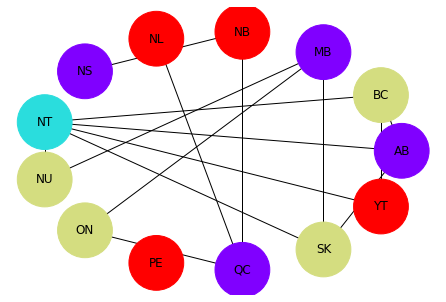

In [10]:
from typing import List
from typing import Tuple
from typing import Dict


def plot_map(sample: Dict[str, bool], provinces: List[str], neighbors: List[Tuple[str]]):
    G = nx.Graph()
    G.add_nodes_from(provinces)
    G.add_edges_from(neighbors)
    color_map = {}
    for province in provinces:
          for i in range(colors):
            if sample[province+str(i)]:
                color_map[province] = i
    node_colors = [color_map.get(node) for node in G.nodes()]
    nx.draw_circular(G, with_labels=True, node_color=node_colors, node_size=3000, cmap=plt.cm.rainbow)
    plt.show()

plot_map(sample, provinces, neighbors)

После запуска функции `plot_map`, мы получим изображение графа, в котором вершины будут соответствовать провинциям и цветам, а ребра -- границам между провинциями. Вы можете сами убедиться, что ни одна провинция не будет иметь такой же цвет, как и ее сосед. Также отметим, что такая задача может иметь не одно решение, поэтому не нужно ожидать, что граф будет получаться всегда одним и тем же.

 Таким образом, мы сумели решить задачу раскраски графа с помощью квантового отжигателя.